In [1]:
import numpy as np
import pandas as pd

import torch
import time
import copy
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, cross_val_score

import brevitas.nn as nn

from config import *
from classic_models import *
from data_preprocessing import *
from feature_extraction import *
from helpers import *

from torch.utils.data import DataLoader
from tslearn.preprocessing import TimeSeriesScalerMinMax

import warnings
warnings.filterwarnings("ignore")

Dance move: 0, Name: gun_john
Dance move: 1, Name: hair_john
Dance move: 2, Name: sidepump_john


In [2]:
from sklearn import preprocessing
df = pd.read_csv('out_2.csv')
# temp = df['tag']
# del df['tag']

# x = df.values #returns a numpy array
# col = df.columns
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled, columns=col)

# df['tag'] = temp
df['tag'] = df['tag'].apply(lambda x: x-1)
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_test = df[~msk]
df.head()

,mean_accel1,mean_accel2,mean_accel3,mean_gyro1,mean_gyro2,mean_gyro3,max_accel1,max_accel2,max_accel3,max_gyro1,...,var_coeff_gyro1,var_coeff_gyro2,var_coeff_gyro3,kurtosis_accel1,kurtosis_accel2,kurtosis_accel3,kurtosis_gyro1,kurtosis_gyro2,kurtosis_gyro3,tag
0,0.321713,0.587304,0.19189,0.224644,0.132784,3.0,0.08,0.412742,-1.510622,0.425019,...,0.512475,0.670569,0.403010,0.465719,0.091719,1.0,0.46,0.178974,-1.346002,0.0
1,0.261652,0.499783,0.16476,0.215231,0.098955,3.0,0.12,0.378192,0.209323,0.482450,...,0.510602,0.670569,0.403010,0.469900,0.086363,2.0,0.34,0.169140,-1.079949,0.0
2,0.221092,0.355008,0.16476,0.212382,0.035674,3.0,0.12,0.161354,4.649814,0.501705,...,0.472475,0.670569,0.177258,0.461538,0.115898,2.0,0.34,0.245300,0.466311,0.0
3,0.294353,0.846729,0.16476,0.217499,0.173952,3.0,0.08,0.590965,3.163390,0.471481,...,0.363211,0.583612,0.053512,0.433110,0.152831,1.0,0.30,0.420778,-0.618947,0.0
4,0.420980,0.906493,0.16476,0.237485,0.272744,4.0,0.00,0.647879,-1.184808,0.502093,...,0.320100,0.481605,0.053512,0.400502,0.149519,1.0,0.26,0.467100,-1.462913,0.0


In [3]:
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        if isinstance(df, pd.DataFrame):
            df_np = df.to_numpy()

        self.X = df_np[:,:-1]
        self.y = df_np[:,-1]

    def __getitem__(self, idx):
        # get item by index
        return self.X[idx], self.y[idx]

    def __len__(self):
        # returns length of data
        return len(self.X)

In [4]:
dataset = FeatureDataset(df_train)
D_in = df.shape[1]-1
D_out = len(dances)

In [9]:
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv1d, MaxPool1d, Module, Softmax, BatchNorm1d, Dropout, Flatten

class CNN(torch.nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super(CNN, self).__init__()
        self.relu = torch.nn.ReLU()
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5)
        self.conv2 = torch.nn.Conv1d(in_channels=64,out_channels=64, kernel_size=5)
        self.conv3 = torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5)
        self.conv4 = torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5)
        self.lstm1 = torch.nn.LSTM(
            input_size=14,
            hidden_size=32,
            num_layers=2,
            batch_first=False,
        )
        self.fc2 = torch.nn.Linear(46, d_out)
        
        self.dropout = torch.nn.Dropout(p=0.1)
        
    def forward(self,x):
        x = x.float().unsqueeze(dim=1)
        x = self.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
#         x = self.relu(self.conv3(x))
#         x = self.relu(self.conv4(x))
#         x,_ = self.lstm1(x)
        x = x[:, -1]
        x = self.fc2(x)
        return x
    
    def load(self, model_path):
        self.load_state_dict(torch.load(model_path))
        self.eval()

    def predict(self, X):
        outputs = self(X.float())
        _, predicted = torch.max(outputs, 1)
        return predicted

In [10]:
model = CNN(D_in, 50, D_out)
# optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Explore the model
for parameter in model.parameters():
    print(parameter.shape)

print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))

torch.Size([64, 1, 5])
torch.Size([64])
torch.Size([64, 64, 5])
torch.Size([64])
torch.Size([64, 64, 5])
torch.Size([64])
torch.Size([64, 64, 5])
torch.Size([64])
torch.Size([128, 14])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([3, 46])
torch.Size([3])
Total number of parameters = 76749


In [11]:
def train_val_model(model, criterion, optimizer, num_epochs=25,
        scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store losses and accuracies accross epochs
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    tscv = TimeSeriesSplit(n_splits=25)

    X_train, X_test, y_train, y_test = train_test_split(
        dataset.X.reshape(dataset.X.shape[0],-1), dataset.y, test_size=0.33, random_state=42
    )

    for i in range(num_epochs):
        if log_interval is not None and i % log_interval == 0:
            print('Epoch {}/{}'.format(i, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
        for fold, (train_index, test_index) in enumerate(tscv.split(X_train, y_train)):
            ### Dividing data into folds
            x_train_fold = X_train[train_index]
            x_test_fold = X_train[test_index]
            y_train_fold = y_train[train_index]
            y_test_fold = y_train[test_index]

            print('Train Index Length:', len(x_train_fold), end='\t\t')
            print('Test Index Length:', len(x_test_fold), end='\n\n')

            train = torch.utils.data.TensorDataset(torch.tensor(x_train_fold), torch.tensor(y_train_fold))
            test = torch.utils.data.TensorDataset(torch.tensor(x_test_fold), torch.tensor(y_test_fold))
            train_loader = torch.utils.data.DataLoader(train, batch_size = 20, shuffle = False)
            test_loader = torch.utils.data.DataLoader(test, batch_size = 20, shuffle = False)

        
            running_loss = 0.0
            running_corrects = 0
            model.train()
            for batch_index, (x_batch, y_batch) in enumerate(train_loader):
                optimizer.zero_grad()
                y_pred = model(x_batch)
                _, preds = torch.max(y_pred, 1)
                
                single_loss = criterion(y_pred, y_batch.long().view(-1))
                single_loss.backward()
                optimizer.step()
                
                running_loss += single_loss.item() * x_batch.size(0)
                running_corrects += torch.sum(preds == y_batch.data)
            print('Fold No. {}/{}\tEpoch {}/{}\t'.format(fold + 1 , tscv.get_n_splits(), i + 1, num_epochs), end='')
            print(f'loss: {single_loss.item():10.8f}')
            
            nsamples = len(train_index)
            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if log_interval is not None and i % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                    phase, epoch_loss, 100 * epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.2f}%'.format(100 * best_acc))
    print()

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies

In [12]:
model, losses, accuracies = train_val_model(model, criterion, optimizer, num_epochs=15, log_interval=1)

Epoch 0/14
----------
Train Index Length: 34		Test Index Length: 12

Fold No. 1/25	Epoch 1/15	loss: 1.10852468
val Loss: 1.1222 Acc: 14.71%
Train Index Length: 46		Test Index Length: 12

Fold No. 2/25	Epoch 1/15	loss: 1.07540643
val Loss: 1.1042 Acc: 19.57%
Train Index Length: 58		Test Index Length: 12

Fold No. 3/25	Epoch 1/15	loss: 1.10032523
val Loss: 1.1009 Acc: 18.97%
Train Index Length: 70		Test Index Length: 12

Fold No. 4/25	Epoch 1/15	loss: 1.09418845
val Loss: 1.1003 Acc: 21.43%
Train Index Length: 82		Test Index Length: 12

Fold No. 5/25	Epoch 1/15	loss: 1.07190204
val Loss: 1.0955 Acc: 29.27%
Train Index Length: 94		Test Index Length: 12

Fold No. 6/25	Epoch 1/15	loss: 1.08426726
val Loss: 1.0943 Acc: 27.66%
Train Index Length: 106		Test Index Length: 12

Fold No. 7/25	Epoch 1/15	loss: 1.11070693
val Loss: 1.0970 Acc: 22.64%
Train Index Length: 118		Test Index Length: 12

Fold No. 8/25	Epoch 1/15	loss: 1.08891547
val Loss: 1.0920 Acc: 29.66%
Train Index Length: 130		Test In

Fold No. 19/25	Epoch 3/15	loss: 0.58222377
val Loss: 0.7413 Acc: 73.60%
Train Index Length: 262		Test Index Length: 12

Fold No. 20/25	Epoch 3/15	loss: 0.47212487
val Loss: 0.7226 Acc: 74.81%
Train Index Length: 274		Test Index Length: 12

Fold No. 21/25	Epoch 3/15	loss: 0.77604574
val Loss: 0.7329 Acc: 71.17%
Train Index Length: 286		Test Index Length: 12

Fold No. 22/25	Epoch 3/15	loss: 0.87223291
val Loss: 0.6909 Acc: 76.22%
Train Index Length: 298		Test Index Length: 12

Fold No. 23/25	Epoch 3/15	loss: 0.58073968
val Loss: 0.6935 Acc: 73.49%
Train Index Length: 310		Test Index Length: 12

Fold No. 24/25	Epoch 3/15	loss: 0.55288857
val Loss: 0.6880 Acc: 72.90%
Train Index Length: 322		Test Index Length: 12

Fold No. 25/25	Epoch 3/15	loss: 1.11544812
val Loss: 0.6537 Acc: 79.19%
Epoch 3/14
----------
Train Index Length: 34		Test Index Length: 12

Fold No. 1/25	Epoch 4/15	loss: 0.79301864
val Loss: 0.7072 Acc: 52.94%
Train Index Length: 46		Test Index Length: 12

Fold No. 2/25	Epoch 4

Fold No. 14/25	Epoch 6/15	loss: 0.49173212
val Loss: 0.4706 Acc: 83.16%
Train Index Length: 202		Test Index Length: 12

Fold No. 15/25	Epoch 6/15	loss: 0.17539471
val Loss: 0.4897 Acc: 80.69%
Train Index Length: 214		Test Index Length: 12

Fold No. 16/25	Epoch 6/15	loss: 0.24514617
val Loss: 0.5023 Acc: 79.91%
Train Index Length: 226		Test Index Length: 12

Fold No. 17/25	Epoch 6/15	loss: 1.05335140
val Loss: 0.5191 Acc: 78.76%
Train Index Length: 238		Test Index Length: 12

Fold No. 18/25	Epoch 6/15	loss: 0.51339996
val Loss: 0.4567 Acc: 82.77%
Train Index Length: 250		Test Index Length: 12

Fold No. 19/25	Epoch 6/15	loss: 0.29872993
val Loss: 0.5106 Acc: 82.40%
Train Index Length: 262		Test Index Length: 12

Fold No. 20/25	Epoch 6/15	loss: 0.29759893
val Loss: 0.4491 Acc: 85.50%
Train Index Length: 274		Test Index Length: 12

Fold No. 21/25	Epoch 6/15	loss: 0.67648035
val Loss: 0.4610 Acc: 82.48%
Train Index Length: 286		Test Index Length: 12

Fold No. 22/25	Epoch 6/15	loss: 0.753709

Fold No. 7/25	Epoch 9/15	loss: 0.16786541
val Loss: 0.2902 Acc: 85.85%
Train Index Length: 118		Test Index Length: 12

Fold No. 8/25	Epoch 9/15	loss: 0.23889650
val Loss: 0.3264 Acc: 86.44%
Train Index Length: 130		Test Index Length: 12

Fold No. 9/25	Epoch 9/15	loss: 0.42766556
val Loss: 0.3839 Acc: 82.31%
Train Index Length: 142		Test Index Length: 12

Fold No. 10/25	Epoch 9/15	loss: 0.06049542
val Loss: 0.3025 Acc: 87.32%
Train Index Length: 154		Test Index Length: 12

Fold No. 11/25	Epoch 9/15	loss: 0.34145498
val Loss: 0.3175 Acc: 88.31%
Train Index Length: 166		Test Index Length: 12

Fold No. 12/25	Epoch 9/15	loss: 0.67349046
val Loss: 0.3283 Acc: 85.54%
Train Index Length: 178		Test Index Length: 12

Fold No. 13/25	Epoch 9/15	loss: 0.42418575
val Loss: 0.3418 Acc: 89.33%
Train Index Length: 190		Test Index Length: 12

Fold No. 14/25	Epoch 9/15	loss: 0.29123735
val Loss: 0.3537 Acc: 87.37%
Train Index Length: 202		Test Index Length: 12

Fold No. 15/25	Epoch 9/15	loss: 0.37432349


Fold No. 4/25	Epoch 12/15	loss: 0.22016057
val Loss: 0.3219 Acc: 85.71%
Train Index Length: 82		Test Index Length: 12

Fold No. 5/25	Epoch 12/15	loss: 0.15779935
val Loss: 0.3094 Acc: 87.80%
Train Index Length: 94		Test Index Length: 12

Fold No. 6/25	Epoch 12/15	loss: 0.35527888
val Loss: 0.3289 Acc: 86.17%
Train Index Length: 106		Test Index Length: 12

Fold No. 7/25	Epoch 12/15	loss: 0.10397185
val Loss: 0.2677 Acc: 90.57%
Train Index Length: 118		Test Index Length: 12

Fold No. 8/25	Epoch 12/15	loss: 0.20490725
val Loss: 0.3469 Acc: 85.59%
Train Index Length: 130		Test Index Length: 12

Fold No. 9/25	Epoch 12/15	loss: 0.17031589
val Loss: 0.2858 Acc: 87.69%
Train Index Length: 142		Test Index Length: 12

Fold No. 10/25	Epoch 12/15	loss: 0.07462581
val Loss: 0.3475 Acc: 87.32%
Train Index Length: 154		Test Index Length: 12

Fold No. 11/25	Epoch 12/15	loss: 0.27016833
val Loss: 0.3193 Acc: 86.36%
Train Index Length: 166		Test Index Length: 12

Fold No. 12/25	Epoch 12/15	loss: 0.43682

Fold No. 22/25	Epoch 14/15	loss: 0.18638979
val Loss: 0.3184 Acc: 88.46%
Train Index Length: 298		Test Index Length: 12

Fold No. 23/25	Epoch 14/15	loss: 0.29101029
val Loss: 0.2869 Acc: 88.93%
Train Index Length: 310		Test Index Length: 12

Fold No. 24/25	Epoch 14/15	loss: 0.16768974
val Loss: 0.2989 Acc: 88.39%
Train Index Length: 322		Test Index Length: 12

Fold No. 25/25	Epoch 14/15	loss: 1.27755558
val Loss: 0.2916 Acc: 87.27%
Epoch 14/14
----------
Train Index Length: 34		Test Index Length: 12

Fold No. 1/25	Epoch 15/15	loss: 0.35890809
val Loss: 0.3121 Acc: 91.18%
Train Index Length: 46		Test Index Length: 12

Fold No. 2/25	Epoch 15/15	loss: 0.14034992
val Loss: 0.1988 Acc: 95.65%
Train Index Length: 58		Test Index Length: 12

Fold No. 3/25	Epoch 15/15	loss: 0.26761100
val Loss: 0.2678 Acc: 87.93%
Train Index Length: 70		Test Index Length: 12

Fold No. 4/25	Epoch 15/15	loss: 0.13548985
val Loss: 0.3250 Acc: 88.57%
Train Index Length: 82		Test Index Length: 12

Fold No. 5/25	Epoc

In [13]:
torch.save(model.state_dict(), 'CNN_Model')

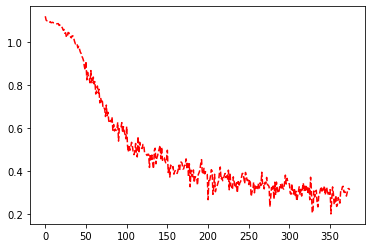

In [14]:
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [15]:
cnn_model = CNN(D_in, 50, D_out)
cnn_model.load('CNN_Model')
cnn_model.eval()

for to_predict in range(D_out):
    df_target = df_test[df_test['tag'] == to_predict]

    df_random = df_test

    df_filtered = torch.from_numpy(np.array(pd.merge(df_target, df_random))[:,:-1])
    output = cnn_model.predict(df_filtered)
    # print(output)
    proba_dict = {}

    for x in output:
        x = int(x)
        if x not in proba_dict:
            proba_dict[x] = 1
        else:
            proba_dict[x] += 1
    for k in proba_dict.keys():
        proba_dict[k] /= len(output)

    print(dict(sorted(proba_dict.items(), key=lambda item: -item[1])))

{0: 0.8076923076923077, 2: 0.15384615384615385, 1: 0.038461538461538464}
{1: 1.0}
{2: 0.8529411764705882, 0: 0.14705882352941177}
